In [1]:
%load_ext autoreload
%autoreload 2
p = print

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from crypr.zoo import LSTM_triggerNG, LSTM_WSAEs
from crypr.util import get_project_path

Using TensorFlow backend.


In [2]:
SYM = 'BTC'
Tx = 72
Ty = 1
wavelet = 'MORLET'
N = 28
data_dir = os.path.join(get_project_path(), 'data', 'processed')

"""
Import Data.
"""
def load_preprocessed_data(from_dir, sym, tx, wavelet, n=None):
    X_train = np.load(os.path.join(data_dir, 'X_train_{}_{}_{}x{}.npy'.format(sym, wavelet, n, tx)))
    X_test = np.load(os.path.join(data_dir, 'X_test_{}_{}_{}x{}.npy'.format(sym, wavelet, n, tx)))
    y_train = np.load(os.path.join(data_dir, 'y_train_{}_{}_{}x{}.npy'.format(sym, wavelet, n, tx)))
    y_test = np.load(os.path.join(data_dir, 'y_test_{}_{}_{}x{}.npy'.format(sym, wavelet, n, tx)))
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_preprocessed_data(data_dir, SYM, Tx, wavelet, N)
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((5629, 28, 72), (297, 28, 72), (297, 1), (5629, 1))

In [3]:
"""
Evaluate Dummy Models.
"""
for strategy in ['mean', 'median', 'constant']:
    if strategy == 'constant':
        dummy = DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy = DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    dummy_predict_train = dummy.predict(X_train)
    
    p('\nPerformance on train data:')
    p('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_train, y_pred=dummy_predict_train)))
    p('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    p('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_test, y_pred=dummy_predict_test)))
    p('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.3685907822780149
mean MSE: 0.48241478792244674

Performance on test data:
mean MAE: 0.22173177276079079
mean MSE: 0.21816986175239914

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.3684412225573951
median MSE: 0.48250360760060407

Performance on test data:
median MAE: 0.22109031078430322
median MSE: 0.2185175953046493

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.3684570118593815
constant MSE: 0.48245071329994665

Performance on test data:
constant MAE: 0.22124047352234621
constant MSE: 0.21837045216673828


### Define RNN

In [4]:
model_type = 'LSTM_WSAEs'

if model_type == 'LSTM_triggerNG':
    model = LSTM_triggerNG(X_train.shape[1:], )
elif model_type == 'LSTM_WSAEs':
    model = LSTM_WSAEs(Tx, N, Ty)
else:
    raise NotImplementedError

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 72)       0                                            
__________________________________________________________________________________________________
encoder (Dense)                 (None, 28, 41)       2993        input_1[0][0]                    
__________________________________________________________________________________________________
encoded (Dense)                 (None, 28, 10)       420         encoder[0][0]                    
__________________________________________________________________________________________________
rs_0 (Reshape)                  (None, 10, 28)       0           encoded[0][0]                    
_____________________________________

### Train RNN 

In [5]:
"""
Set model training parameters.
"""
epochs = 10
batch_size = 32
learning_rate = 1e-3
beta_1 = 0.9
beta_2 = 0.999
decay = 0.01  # TODO: calculated decay rate -- decay = learning_rate / epochs

"""
Logging params.
"""
tensorboard = TensorBoard(log_dir='logs/{}'.format(model_type), histogram_freq=0, batch_size=batch_size, 
                          write_graph=True, write_grads=False, write_images=False)

"""
Compile and fit model.
"""

opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)

model.compile(loss='mae', optimizer=opt)

fit = model.fit(X_train, 
                [X_train, y_train],
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(X_test, [X_test, y_test]),
                callbacks=[tensorboard],
               )

Instructions for updating:
Use tf.cast instead.
Train on 5629 samples, validate on 297 samples
Epoch 1/10
5629/5629 [==============================] - 4s 764us/step - loss: 0.7311 - decoded_loss: 0.3555 - dense_0_loss: 0.3756 - val_loss: 0.5833 - val_decoded_loss: 0.2901 - val_dense_0_loss: 0.2933
Epoch 2/10
5629/5629 [==============================] - 3s 481us/step - loss: 0.6970 - decoded_loss: 0.3309 - dense_0_loss: 0.3661 - val_loss: 0.5995 - val_decoded_loss: 0.2663 - val_dense_0_loss: 0.3332
Epoch 3/10
5629/5629 [==============================] - 3s 466us/step - loss: 0.6756 - decoded_loss: 0.3120 - dense_0_loss: 0.3636 - val_loss: 0.5807 - val_decoded_loss: 0.2502 - val_dense_0_loss: 0.3305
Epoch 4/10
5629/5629 [==============================] - 3s 477us/step - loss: 0.6604 - decoded_loss: 0.2985 - dense_0_loss: 0.3618 - val_loss: 0.5655 - val_decoded_loss: 0.2388 - val_dense_0_loss: 0.3266
Epoch 5/10
5629/5629 [==============================] - 3s 481us/step - loss: 0.6493 - de

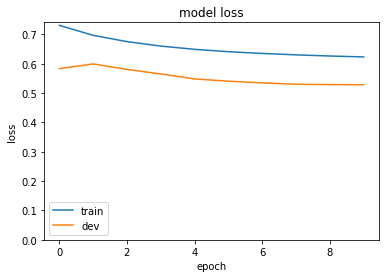

In [6]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='dev')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

### Predict 

In [7]:
backtest = model.predict(X_train)
prediction = model.predict(X_test)

# Select price prediction in multiple output models
if len(backtest) == 2:
    backtest = backtest[1]
    prediction = prediction[1]

### Evaluate Predictions on Test (unseen) Data

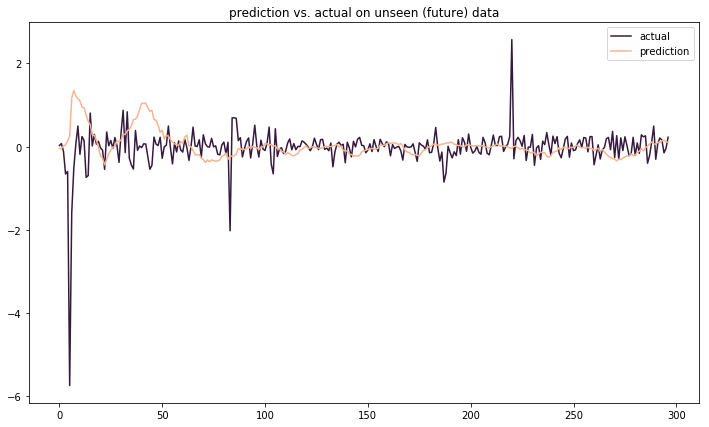

In [8]:
fig,ax = plt.subplots(figsize=(12,7))
plt.plot(y_test, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()
plt.show()

### Evaluate Predictions for Training Data

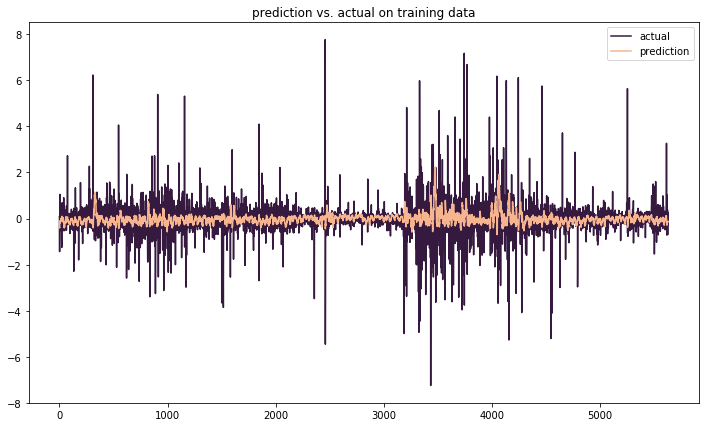

In [9]:
fig,ax = plt.subplots(figsize=(12,7))
plt.plot(y_train, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()
plt.show()

In [11]:
# Save the model
models_dir = os.path.join(get_project_path(), 'models')
model.save(filepath=os.path.join(models_dir, '{}_cwt_{}x{}_{}_{}.h5'.format(model_type, N, Tx, wavelet, SYM)))